In [3]:
%reload_ext autoreload
%autoreload 2

from copy import deepcopy
from python_modules import constants, evaluation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import time

In [4]:
TIMESTAMP="timestamp"
ID="id"
VIEW="view"

parameters_df, cyclon_df = evaluation.fetch_results("output/second/")
n_experiments=len(parameters_df)

In [5]:
parameters_df

debug_cy  experiment_duration  experiment_id  gossip_size  log_cy  \
6         0                   60              0            6       1   
8         0                   60              1            6       1   
4         0                   60              2            6       1   
0         0                   60              3            6       1   
2         0                   60              4            6       1   
9         0                   60              5            6       1   
3         0                   60              6            6       1   
5         0                   60              7            6       1   
1         0                   60              8            6       1   
7         0                   60              9            6       1   

   n_devices  period  view_size                        path  
6         50       1         10  output/second/experiment0/  
8         50       1         10  output/second/experiment1/  
4         50       1         10  output/second/experiment2/  
0         50       1         10  output/second/experiment3/  
2         50       1         10  output/second/experiment4/  
9         50       1         10  output/second/experiment5/  
3         50       1         10  output/second/experiment6/  
5         50       1         10  output/second/experiment7/  
1         50       1         10  output/second/experiment8/  
7         50       1         10  output/second/experiment9/

## Evaluate output graph

In [120]:
# We create a random graph w/ fixed out degree per node
# and compute its average_shortest_path_length
def average_shortest_path_length_random(n_nodes, out_degree):
    randomG=nx.Graph()
    node_ids=list(range(n_nodes))
    for nid in node_ids:
        neighbors = deepcopy(node_ids)
        neighbors.remove(nid)
        neighbors = random.sample(neighbors, out_degree)
        
        randomG.add_edges_from(zip([nid]*out_degree, neighbors))
    
    if nx.is_connected(randomG):
        return nx.average_shortest_path_length(randomG)
    else:
        Gc = max(nx.connected_component_subgraphs(G), key=len)
        return nx.average_shortest_path_length(Gc)

In [156]:
%matplotlib inline

results_df = pd.DataFrame()

for experiment_id in range(n_experiments):
    experiment_df = cyclon_df[cyclon_df['experiment_id'] == experiment_id]
    
    n_points=parameters_df[
        parameters_df['experiment_id'] == experiment_id
    ]['experiment_duration'].values[0]

    timestamps = pd.to_datetime(
        np.linspace(experiment_df[TIMESTAMP].min().value, 
                    experiment_df[TIMESTAMP].max().value,
                    num=n_points+1))

    for i in range(n_points):
        tstart=timestamps[i]
        tend=timestamps[i+1]

#         df = experiment_df[(experiment_df[TIMESTAMP] >= tstart) &
#                            (experiment_df[TIMESTAMP] < tend)]
        df = experiment_df[(experiment_df[TIMESTAMP] >= tstart)]
        if i != n_points - 1:
            df = df[df[TIMESTAMP] < tend]

        # As in the Cyclon paper, 
        # we only take interest in the undirected version of the graph 
        G = nx.Graph()
        for _, s in df.iterrows():
            view = s[VIEW]
            G.add_edges_from(list(zip([s[ID]]*len(view), view)))
            
#         nx.draw(G)
#         plt.show()
#         time.sleep(0.1)
        
        # Compute average shortest path length
        if nx.is_connected(G):
            path_length = nx.average_shortest_path_length(G)
        else:
            # When the graph is not connected, take the average 
            # shortest path length of its biggest connected component
            Gc = max(nx.connected_component_subgraphs(G), key=len)
            path_length = nx.average_shortest_path_length(Gc)
        
        # We compare against random graphs
        # The formula is from the Cyclon paper
        view_size = parameters_df[parameters_df['experiment_id'] == experiment_id
                                 ]['view_size'].values[0]
        n_devices = parameters_df[parameters_df['experiment_id'] == experiment_id
                                 ]['n_devices'].values[0]
        clustering_coefficient_rand = 2 * view_size / (n_devices - 1)
        
        results_df = results_df.append(pd.Series({
            'experiment_id': experiment_id,
            'datum': i,
            'timestamp': tstart,
            'clustering_coefficient': nx.average_clustering(G),
            'average_shortest_path_length': path_length,
            'clustering_coefficient_random': clustering_coefficient_rand,
            'average_shortest_path_length_random': \
                average_shortest_path_length_random(n_devices, view_size)
        }), ignore_index=True)
    

results_df

average_shortest_path_length  average_shortest_path_length_random  \
0                        1.583333                             1.630204   
1                        1.636364                             1.640816   
2                        1.583333                             1.640000   
3                        1.719298                             1.632653   
4                        1.645022                             1.635102   
5                        1.698462                             1.636735   
6                        1.817460                             1.626939   
7                        1.778226                             1.640000   
8                        1.751261                             1.638367   
9                        1.811066                             1.636735   
10                       1.744483                             1.630204   
11                       1.782609                             1.636735   
12                       1.845238                             1.630204   
13                       1.820408                             1.629388   
14                       1.737959                             1.636735   
15                       1.759354                             1.635102   
16                       1.755102                             1.630204   
17                       1.776327                             1.632653   
18                       1.725714                             1.639184   
19                       1.804898                             1.632653   
20                       1.703673                             1.626122   
21                       1.732245                             1.634286   
22                       1.713469                             1.635918   
23                       1.581224                             1.632653   
24                       1.618776                             1.629388   
25                       1.623673                             1.633469   
26                       1.606531                             1.626939   
27                       1.612245                             1.622857   
28                       1.690612                             1.635918   
29                       1.623673                             1.625306   
..                            ...                                  ...   
550                      1.604898                             1.635918   
551                      1.551020                             1.637551   
552                      1.647347                             1.631837   
553                      1.637551                             1.628571   
554                      1.601633                             1.640816   
555                      1.566531                             1.628571   
556                      1.572245                             1.628571   
557                      1.533878                             1.631837   
558                      1.573061                             1.628571   
559                      1.507755                             1.631020   
560                      1.555102                             1.632653   
561                      1.530612                             1.633469   
562                      1.527347                             1.637551   
563                      1.580408                             1.635102   
564                      1.564082                             1.635102   
565                      1.584490                             1.634286   
566                      1.531429                             1.635102   
567                      1.563265                             1.641633   
568                      1.566531                             1.635918   
569                      1.556735                             1.631837   
570                      1.595102                             1.639184   
571                      1.498776                             1.644898   
572      

In [157]:
results_mean = results_df.groupby('datum').mean()
results_std = results_df.groupby('datum').std()

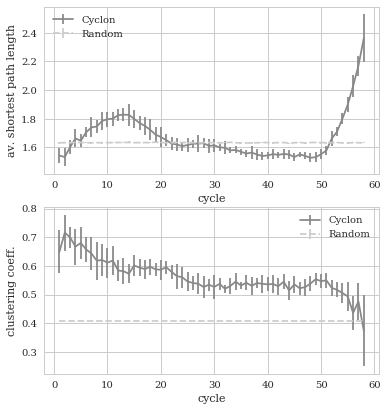

In [158]:
sns.set_context('paper')
sns.set(font='serif')
sns.set_style("whitegrid", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
# mpl.rc('text', usetex=True)
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

SIZE = 6
fig, axarr = plt.subplots(ncols=1, nrows=2, figsize=(SIZE, 2* (SIZE * 9 / 16)))

# shortest path
axarr[0].errorbar(results_mean.index,
                  results_mean['average_shortest_path_length'], 
                  yerr=results_std['average_shortest_path_length'],
                  color="#888888", label='Cyclon')
axarr[0].errorbar(results_mean.index,
                  results_mean['average_shortest_path_length_random'], 
                  yerr=results_std['average_shortest_path_length_random'],
                  color="#cccccc", linestyle='dashed', label='Random')
#axarr[0].set_xlabel("cycle")
axarr[0].set_ylabel("av. shortest path length")
axarr[0].legend()

# Clustering coefficient
axarr[1].errorbar(results_mean.index,
                  results_mean['clustering_coefficient'], 
                  yerr=results_std['clustering_coefficient'],
                  color="#888888", label='Cyclon')
axarr[1].errorbar(results_mean.index,
                  results_mean['clustering_coefficient_random'], 
                  yerr=results_std['clustering_coefficient_random'],
                  color="#cccccc", linestyle='dashed', label='Random')
axarr[1].set_xlabel("cycle")
axarr[1].set_ylabel("clustering coeff.")
axarr[1].legend()

plt.savefig("it_works.svg")
plt.show()